In [31]:
import numpy as np
from hmmlearn.hmm import MultinomialHMM
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
import matplotlib.pyplot as plt
np.random.seed(200263453)

In [2]:
rand_p_matrix = np.random.rand(4,4)
rand_b_matrix = np.random.rand(4,3)

In [3]:
def normalization(matrix):
    print ("Checking each row's sum of prob. is equal to 1.")
    for i in range(len(matrix)):
        total = sum(matrix[i])
        for j in range(len(matrix[i])):
            matrix[i][j] = matrix[i][j] / total
        print("Sum of row[{}] is {}".format(i, sum(matrix[i])))
    return matrix

In [4]:
print ("Gernerating p matrix...............")
p_matrix = normalization(rand_p_matrix)
print (p_matrix)

Gernerating p matrix...............
Checking each row's sum of prob. is equal to 1.
Sum of row[0] is 1.0
Sum of row[1] is 0.9999999999999999
Sum of row[2] is 0.9999999999999998
Sum of row[3] is 1.0
[[0.25691376 0.17040213 0.46721004 0.10547407]
 [0.10696801 0.16903803 0.48485879 0.23913518]
 [0.17139729 0.37094994 0.33560144 0.12205134]
 [0.08770787 0.29766955 0.01358607 0.60103652]]


In [5]:
print ("Gernerating b matrix...............")
b_matrix = normalization(rand_b_matrix)
print (b_matrix)

Gernerating b matrix...............
Checking each row's sum of prob. is equal to 1.
Sum of row[0] is 1.0
Sum of row[1] is 1.0
Sum of row[2] is 1.0
Sum of row[3] is 0.9999999999999999
[[0.30500857 0.11587838 0.57911305]
 [0.30627907 0.59700434 0.09671658]
 [0.51807384 0.12990698 0.35201919]
 [0.3496476  0.35823218 0.29212022]]


In [23]:
# Identify observation
def get_observation(state):
    v = [1,2,3] # states
    return np.random.choice(v, 1, p = b_matrix[state-1])[0]

# Get the shift state
def get_shift_state(state):
    S = [1,2,3,4]
    return np.random.choice(S, 1, p = p_matrix[state-1])[0]

In [24]:
def generate_observation(n):
    Q = [1]
    O = []
    O.append(get_oberservation(Q[-1]))
    while len(O) < n:
        Q.append(get_shift_state(Q[-1]))
        O.append(get_observation(Q[-1]))
    return O, Q

# Generate 1000 observations
O,Q = generate_observation(1000)

In [8]:
# Task 2 Estimate 𝒑(𝑶|𝝀)
O_seq = [1,2,3,3,1,2,3,3,1,2,3,3]
pi = (1,0,0,0)
def forward(obs_seq):
    T = len(obs_seq)
    N = p_matrix.shape[0]
    alpha = np.zeros((T, N))
    alpha[0] = pi*b_matrix[:,obs_seq[0]-1]
    for t in range(1, T):
        alpha[t] = alpha[t-1].dot(p_matrix) * b_matrix[:, obs_seq[t]-1]
    return alpha

print("The Orginal Observation Sequence O: {}".format(O[:12])) 
print("The probability 𝑝(𝑂|𝜆) is {} with O: {}".format(forward(O_seq)[-1].sum(), O_seq))   

The Orginal Observation Sequence O: [3, 3, 2, 3, 1, 2, 1, 2, 1, 1, 3, 3]
The probability 𝑝(𝑂|𝜆) is 7.759208566964466e-07 with O: [1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3]


In [9]:
def viterbi(obs_seq):
    # returns the most likely state sequence given observed sequence x
    # using the Viterbi algorithm
    T = len(obs_seq)
    N = p_matrix.shape[0]
    delta = np.zeros((T, N))
    psi = np.zeros((T, N))
    delta[0] = pi * b_matrix[:,obs_seq[0]-1]
    for t in range(1, T):
        for j in range(N):
            delta[t,j] = np.max(delta[t-1] * p_matrix[:,j]) * b_matrix[j, obs_seq[t]-1]
            psi[t,j] = np.argmax(delta[t-1] * p_matrix[:,j])
    # backtrack
    states = np.zeros(T, dtype=np.int32)
    states[T-1] = np.argmax(delta[T-1])
    for t in range(T-2, -1, -1):
        states[t] = psi[t+1, states[t+1]]
    return states + 1

print("The Orginal Sequence Q: {}".format(Q[:12])) 
print("The Most Probable Sequence Q: {} with O: {}".format(list(viterbi(O_seq)), O_seq))

The Orginal Sequence Q: [1, 3, 2, 3, 2, 2, 3, 2, 3, 2, 3, 3]
The Most Probable Sequence Q: [1, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4] with O: [1, 2, 3, 3, 1, 2, 3, 3, 1, 2, 3, 3]


In [10]:
obersvations = LabelEncoder().fit_transform(O)
model = MultinomialHMM(n_components=4, random_state=200263453)
model.fit(np.atleast_2d(obersvations))
est_pi = model.startprob_
est_p = model.transmat_
est_b = model.emissionprob_
print("\nThe estimated transition matrix P:\n {}".format(est_p))
print("\nThe estimated event matrix B:\n {}".format(est_b))
print("\nThe estimated start probability pi:\n {}".format(est_pi))


The estimated transition matrix P:
 [[0.24089929 0.2433524  0.25590455 0.25984376]
 [0.2338624  0.24164307 0.25549448 0.26900004]
 [0.23552676 0.24905907 0.2443094  0.27110476]
 [0.22807157 0.24670467 0.24436792 0.28085584]]

The estimated event matrix B:
 [[0.29599125 0.25341334 0.45059541]
 [0.28618943 0.36068252 0.35312805]
 [0.46970822 0.29850055 0.23179123]
 [0.41090241 0.48293571 0.10616188]]

The estimated start probability pi:
 [9.03856202e-01 9.45757724e-02 1.56734096e-03 6.84299128e-07]


In [11]:
chi, p = chisquare(p_matrix, est_p, axis=None)
print ("p-value of transition matrix P: {}".format(p))
chi, p = chisquare(b_matrix,est_b, axis=None)
print ("p-value of event matrix B: {}".format(p))
chi, p = chisquare(pi,est_pi, axis=None)
print ("p-value of start probability pi: {}".format(p))

p-value of transition matrix P: 0.9999964230241212
p-value of event matrix B: 0.9999536646387183
p-value of start probability pi: 0.9910621095427448


In [12]:
from collections import Counter
cnt = Counter(O)
for k in sorted(cnt.keys()):
    print ("Number of observation object {} is {}".format(k, cnt[k])) 

Number of observation object 1 is 368
Number of observation object 2 is 353
Number of observation object 3 is 279


In [75]:
def AIC(logL, p):
    return -2 * logL + 2 * p

def BIC(logL, observations, p):
    T = len(observations)
    return -2 * logL + p * math.log(T)

def compute_p(n,m):
    return m ** 2 + n * m -1

def plot(y, label):
    x = np.arange(2,30)
    plt.plot(x,y, marker='o', color='blue', linewidth=2, label=label)
    plt.xlabel('Number of states')
    plt.ylabel(label)
    plt.title('Selection of number of states -{}'.format(label))
    plt.savefig('{}.png'.format(label))
    plt.show()

In [76]:
aic = []
bic = []
likelihood = []
m = 3
import math
for n in range(2,30):
    observations = LabelEncoder().fit_transform(O)
    model = MultinomialHMM(n_components=n, random_state=200263453)
    model.fit(np.atleast_2d(observations))
    logL = model.score(np.atleast_2d(observations))
    p = compute_p(n,m)
    a = AIC(logL, p)
    b = BIC(logL, observations, p)
    likelihood.append(logL)
    aic.append(a)
    bic.append(b)

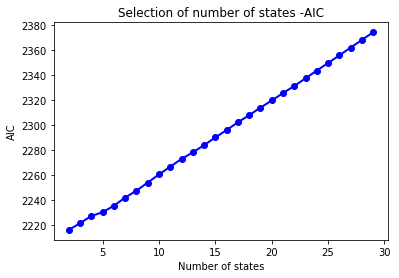

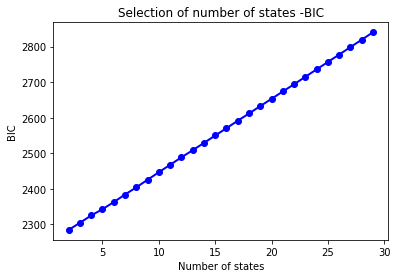

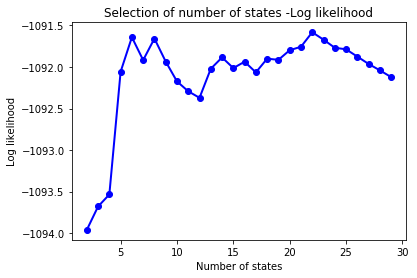

In [77]:
plot(aic,'AIC')
plot(bic,'BIC')
plot(likelihood,'Log likelihood')